# Short Lab 3 : Proximal/cyclic/greedy coordinate descent

#### Authors: M. Massias, P. Ablin

## Aim

The aim of this material is to code 
- cyclic and greedy coordinate descent for ordinary least squares (OLS)
- proximal gradient descent for sparse Logistic regression

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 11th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 5 novembre 2017**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [146]:
# Change here using YOUR first and last names
fn1 = "Yu"
ln1 = "Xiang"
fn2 = "Jean"
ln2 = "Babin"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab3", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab3_xiang_yu_and_babin_jean.ipynb


In [340]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit
from time import time

from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn

In [341]:
# the usual functions:




def simu(coefs, n_samples=1000, corr=0.5, for_logreg=False):
    n_features = len(coefs)
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    b = A.dot(coefs) + randn(n_samples)
    if for_logreg:
        b = np.sign(b)
    return A, b


## Part 1: Ordinary Least Squares


Let $A \in \mathbb{R}^{n \times p}$, $y \in \mathbb{R}^n$.
We want to use coordinate descent to solve:
    $$\hat w \in  \mathrm{arg \, min \,} \frac 12 \Vert Aw - b \Vert ^2 $$

We ask you to code:
- cyclic coordinate descent: at iteration $t$, update feature $j = t \mod p$
- greedy coordinate descent: at iteration $t$, update feature having the largest partial gradient in magnitude, ie $j = \mathrm{arg\, max \,}_{i} \vert \nabla_i f(w_t) \vert$.


**WARNING**: You must do this in a clever way, ie such that $p$ updates cost the same as one update of GD.

In [149]:
n_features = 100
np.random.seed(1970)

coefs = np.random.randn(n_features)

A, b = simu(coefs, n_samples=1000, for_logreg=False)

Text(0.5, 1.0, 'Real parameters(coefficients)')

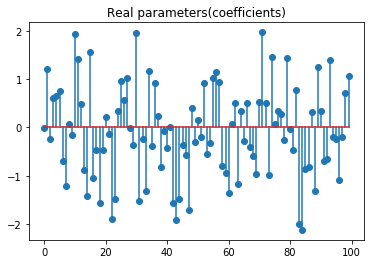

In [150]:
plt.stem(coefs);
plt.title('Real parameters(coefficients)')

In [151]:
def cyclic_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    residuals = b - A.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(A,axis=0) ** 2
    # END TODO
    
    r = residuals.copy()
    for t in range(n_iter):
        j = t % n_features
        
        aj_t =  A.T[j,:]  # the j-th column of A
        
        delta_wj = aj_t.dot(r) / (aj_t.dot(aj_t))   # check whether we really need the lipschtiz constant
        w[j] += delta_wj  # update w for the j-th entry
        
        r -= aj_t * delta_wj   # update residual
        
        if t % n_features == 0:
            all_objs.append(np.linalg.norm(r) ** 2 / 2.)
            # all_objs.append((residuals ** 2).sum() / 2.)
    return w, np.array(all_objs)



def greedy_cd(A, b, n_iter):
    n_samples, n_features = A.shape
    all_objs = []
    
    w = np.zeros(n_features)
    
    gradient = A.T.dot(A.dot(w) - b)  # all the gradient for j = 1, ..., p
    gram = A.T.dot(A)  # you will need this to keep the gradient up to date
    
    r = b - A.dot(w)
    # TODO
    lips_const = np.linalg.norm(A,axis=0) ** 2
    # END TODO 
    
    for t in range(n_iter):
        # TODO
        # choose feature j to update: 
        j = np.argmax(np.abs(gradient))
 
        aj_t =  A.T[j,:]  # the j-th column of A
        delta_wj = aj_t.dot(r) / (aj_t.dot(aj_t)) 
        
        # old_w_j =w.copy() 
        w[j] += delta_wj
        r -= aj_t * delta_wj
        # update gradient:
        gradient += gram[:,j] * delta_wj  
        # END TODO
        
        if t % n_features == 0:
            all_objs.append(0.5 * np.linalg.norm(A.dot(w) - b) ** 2)
    
    return w, np.array(all_objs)

In [154]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [155]:
#@njit    
def grad_i(i, x, A, b):
    """Gradient with respect to a sample"""  
    return  A.T[i,:]  * (A.dot(x) - b)

#@njit
def grad(x, A, b):
    """Full gradient"""
    return  A.T.dot((A.dot(x) - b))

def loss(x, A, b):
    return norm(A.dot(x) - b) ** 2 / 2 


#### Part 1:  compute a precise minimum with your favorite solver

In [156]:
# choose BFGS as my preferable minimizer
from scipy.optimize import fmin_l_bfgs_b
w_init = np.zeros(n_features)
w_min, f_min, _ = fmin_l_bfgs_b(loss, w_init, grad, args=(A, b), pgtol=1e-30, factr=1e-30)

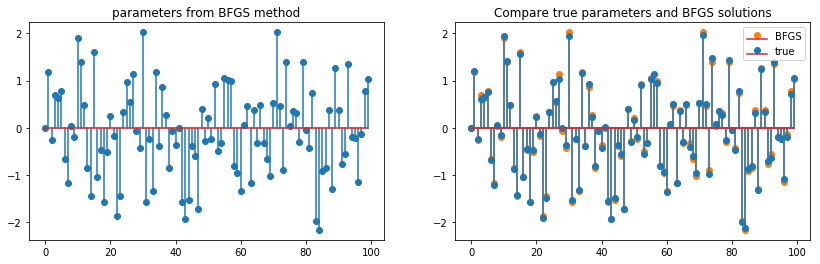

Objective value:  with true parameters: 520.973718778175, with BFGS solutions: 466.3849765337658, BFGS f_min: 466.3849765337658


In [157]:
# show the result of BFGS
plt.figure(figsize=(14., 4.))
plt.subplot(1, 2, 1)
plt.stem(w_min);
plt.title('parameters from BFGS method')

plt.subplot(1, 2, 2)
plt.stem(w_min, label="BFGS", linefmt="C1-", markerfmt="C1o")
plt.stem(coefs, label='true')
plt.title("Compare true parameters and BFGS solutions")
plt.legend(loc=1)
plt.show()

print ("Objective value:  with true parameters: {}, with BFGS solutions: {}, BFGS f_min: {}".format( 
      norm(A.dot(coefs) - b) ** 2 / 2,  norm(A.dot(w_min) - b) ** 2 / 2, f_min))


### Comments:
BFGS solutions better fit the generated $A, b$ than the true parameters 

#### Part 1:  compare the performance of cyclic and greedy CD

In [171]:
n_iter = 500

In [172]:
%timeit w_c, f_c = cyclic_cd(A, b, n_iter)

6.22 ms ± 90.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [173]:
%timeit w_g, f_g = greedy_cd(A, b, n_iter)

11.2 ms ± 501 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Commment: cyclic_cd takes less time than greed_cd

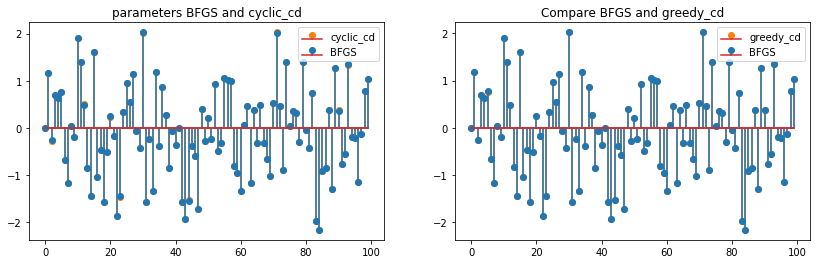

Objective value: BFGS f_min: 466.3849765337658,  cyclic_cd f_min: 466.821491048199, greedy_cd f_min: 466.3926326350476


In [177]:
plt.figure(figsize=(14., 4.))
plt.subplot(1, 2, 1)
plt.stem(w_c, label="cyclic_cd", linefmt="C1-", markerfmt="C1o")
plt.stem(w_min, label='BFGS')
plt.legend(loc=1)
plt.title('parameters BFGS and cyclic_cd')

plt.subplot(1, 2, 2)
plt.stem(w_g, label="greedy_cd", linefmt="C1-", markerfmt="C1o")
plt.stem(w_min, label='BFGS')
plt.title("Compare BFGS and greedy_cd")
plt.legend(loc=1)
plt.show()

print ("Objective value: BFGS f_min: {},  cyclic_cd f_min: {}, greedy_cd f_min: {}".format( 
       f_min, f_c[-1], f_g[-1]))

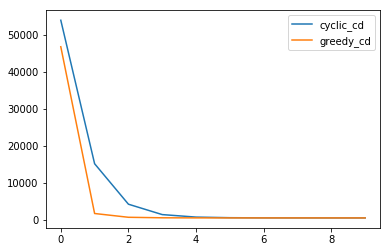

In [178]:
nr_cycle = len(f_c)
plt.plot(np.arange(nr_cycle ), f_c, label="cyclic_cd")
plt.plot(np.arange(nr_cycle ), f_g, label="greedy_cd")
plt.legend(loc=1)
plt.show()

### comment on the performance of cyclic and greedy CD
- greedy CD takes more time to run per iteration than cyclic CD
- greedy CD converges faster by the number of iterations than cyclic CD
- both cyclic CD and greedy CD does well in this case and converges to the optimal solution

This makes sense becasue in the greedy CD, one more step of finding the index of largest gradient is added, and thus slight more time is needed for greedy CD, and therefore greedy CD also have better performance per iteration  

#### Part 1: could you use greedy CD for unregularized logistic regression? for OLS, but with 100,000 features? Explain your answers.


## Part 2: Sparse Logistic regression

### An important result

Remember: we are solving 
$$\hat w \in \mathrm{arg \, min} \sum_{i=1}^{n} \mathrm{log} ( 1 + e^{- y_i w^\top x_i} )  + \lambda \Vert w \Vert_1$$
1) Show that:
$$ \lambda \geq \lambda_{max} \implies \hat w = 0$$
where $\lambda_{max} := \frac 12 \Vert X^\top y \Vert_{\infty}$.


You will need the following beautiful result: for any $w =(w_1, \dots, w_p) \in \mathbb{R}^p$, the subdifferential of the L1 norm at $w$ is:

$$\partial \Vert \cdot \Vert_1 (w) = \partial \vert \cdot \vert_1 (w_1)  \times \dots \times \partial \vert \cdot \vert_1 (w_p) $$
where $\times$ is the Cartesian product between sets,
and $$ \partial \vert \cdot \vert_1 (w_1) = 
\begin{cases} &w_j / |w_j| &\mathrm{if} \quad w_j \neq 0, 
         \\ & [-1, 1] &\mathrm{otherwise.} 
\end{cases}
$$


(it should now be easy to find $\partial \Vert \cdot \Vert_1 (\mathbf{0}_p)$)

*answer here*

2) Show that for sparse Logistic regression the coordinate-wise Lipschitz constant of the smooth term, $\gamma_j$, can be taken equal to $\Vert X_j \Vert^2 / 4$, where $X_j$ denotes the $j$-th column of $X$.

*answer here*

You are now ready to code cyclic proximal coordinate descent for sparse Logistic regression:

**Bonus**: show that is possible, when the current iterate is w, to use the better Lipschitz constant 
    $$ \large \sum_i  \frac{X_{i, j}^2}{(1 + \mathrm{e}^{-y_i X_{i, j} w_j)^2}}$$
    
**Anwswer**: Becase the updated $w_j$ information is included in each step and therefore the lipschitz constant is more precize and the step size will be adaptive compared to the case $\Vert X_j \Vert^2 / 4$

Implement it in the code with a `better_lc` parameter, and compare.

In [372]:
# X, y = simu(coefs, n_samples=1000, for_logreg=True)
# lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
# lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs

#@njit
def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

#@njit
def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)

#@njit
def cd_logreg(X, y, lamb, n_iter, lipid=1):
    # lipid to idicate which lipschizt constant to be choose: 
    #       
    
    
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w) 
     
    lips_const = np.linalg.norm(X, axis = 0) ** 2 / 4.
    all_obj = []
    
    
    for t in range(n_iter):
        for j in range(n_features):  # cyclic cd 
            old_w_j = w[j]        
            Xj = X[:,j]  # the j-th column of x 
            
            if lipid == 1: 
                step = 1 /  lips_const[j] 
                #print (step)
            elif lipid == 2:  # better_lc 
                lips_const_j = np.sum(np.divide(Xj ** 2,   (1 + np.exp(-y * Xj * old_w_j)) ** 2))     
                step  = 1 / lips_const_j
                #print (step)      
            grad_j =  - np.sum(np.multiply(y, Xj) / (1 + np.exp(y * Xw)))
            diff_w_j = old_w_j - step * grad_j
                
            w[j] =  np.sign(diff_w_j) * soft_thresh(diff_w_j, lamb)
            
            if old_w_j != w[j]:
                Xw +=  Xj * (w[j] - old_w_j)
                
        if t % n_features == 0:         
            all_obj.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    return w, all_obj

In [295]:
n_iter = 2000
n_samples, n_features = A.shape

# lambd = 1 / n_samples
# w, all_objs = cd_logreg(A, b, lambd, n_iter,lipid=1)
# w_bt_lc, all_objs_bt_lc = cd_logreg(A, b, lambd, n_iter,lipid=2)




# Part 3: Real data

We will compare vanilla cyclic CD and ISTA to solve the Lasso on a real dataset, called _leukemia_.

You can download the file here: http://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv, and you should place it in the same folder as the current notebook.

In [346]:
from numpy import genfromtxt
y = 2 * (genfromtxt('leukemia_big.csv', delimiter=',', dtype=str)[0] == 'ALL') - 1
X = genfromtxt('leukemia_big.csv', delimiter=',')[1:].T

print(X.shape)
print(y.shape)

(72, 7128)
(72,)


In [365]:
#@njit    
def prox_lasso(w, s):
    """Proximal operator for the Lasso at x"""
    return np.sign(w) * (np.maximum(abs(w)-s,0))

#@njit    
def lasso(w, s):
    """Value of the Lasso penalization at x"""
    return s * norm(w, ord=1)

#@njit    
def grad_logreg(w):
    """Logistic gradient"""
    # all_obj.append(np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1))
    
    c = np.exp(-y * X.dot(w))
    return  np.sum(np.log( 1 + c))

#@njit    
def loss_logreg(w):
    yXw = y * np.dot(X, w)
    return np.sum(np.log(1. + np.exp(- yXw)))

  
def lipschitz_logreg(X):
    return norm(X, ord=2) ** 2 / (4.)

In [354]:
1/ lipschitz_logreg(X),

(9.532453622789366e-06,)

In [366]:
#def ista(x0,  f, grad_f, g, prox_g, step, s=0., n_iter=50, x_true=coefs, verbose=True):
#@njit
def ista(x0,  f, grad_f, g, prox_g, step, s=0., n_iter=50):    
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    #n_samples, n_features = X.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    #err = norm(x - x_true) / norm(x_true)
    #errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)

    
    for k in range(n_iter + 1):

        x = prox_g(x - step * grad_f(x), s)
        
        obj = f(x) + g(x, s)
        objectives.append(obj)
        
    return x, objectives 

In [367]:

f = loss_logreg
grad_f = grad_logreg
g = lasso
prox_g = prox_lasso
lambd = 0
step = 1 / lipschitz_logreg(X)

n_samples = X.shape[0]
n_features = X.shape[1]
x_init = np.zeros(n_features)
x_trues = [] 
n_iter = 500



In [360]:
# w = np.zeros(n_features)
# c = np.exp(-y * X.dot(w))

# np.sum(np.log( 1 + c))

49.90659700031606

In [370]:

w_ista, obj_ista = ista(x_init, f, grad_f, g, prox_g, step, lambd, n_iter)

In [373]:
w_const_lc, obj_const_lc = cd_logreg(X, y, lambd, n_iter,lipid=1)

In [374]:
w_bt_lc, obj_bt_lc = cd_logreg(X, y, lambd, n_iter,lipid=2)

In [378]:
print (w_ista, w_const_lc, obj_bt_lc)

print (obj_bt_lc, obj_const_lc)
#print ( obj_ista)

[-0.2788361 -0.2788361 -0.2788361 ... -0.2788361 -0.2788361 -0.2788361] [-0.67046891  0.03589473 -0.11412588 ...  0.00157913 -0.02586624
  0.0013246 ] [0.1689316328894427]
[0.1689316328894427] [0.1689316328894427]


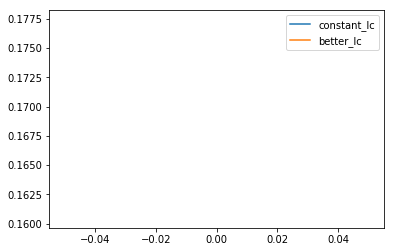

In [377]:
nr_cycle = len(obj_bt_lc)
plt.plot(np.arange(nr_cycle ), obj_const_lc, label="constant_lc")
plt.plot(np.arange(nr_cycle ), obj_bt_lc, label="better_lc")
plt.legend(loc=1)
plt.show()

In [296]:
# nr_cycle = len(all_objs)
# plt.plot(np.arange(nr_cycle ), all_objs, label="constant_lc")
# plt.plot(np.arange(nr_cycle), all_objs_bt_lc, label="better_lc")
# plt.legend(loc=1)
# plt.show()

# ref_x, ref_objectives, ref_errors = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step, s, 1000, coefs, False)
# print ('The precise minimum for fista is: ',  ref_objectives[-1])
# print ('The precise minimizer for fista is: ',  ref_x)

In [297]:
# print ( all_objs, all_objs_bt_lc)

In [298]:
# plt.stem(w_bt_lc)

In [299]:

#lips_const = np.linalg.norm(X, axis = 0) ** 2 / 4.
#lamb = 1 / lips_const[j]

# def lipschitz_logreg(A, b, lbda):
#     return norm(A, ord=2) ** 2 / (4. * n) + lbda
# #lambda_max = norm(A.T.dot(b), ord= np.inf) / 2. 
# lambda_max = norm(A.T.dot(b), ord= np.inf) / (2. * n_samples) 
# #lambd = lambda_max / 1000.  
# lambd = lambda_max / 1000






# print (lambd, lambda_max,  1. / n ** (0.5) )

# j = 1
# w = np.zeros(n_features)
# X = A
# Xw = X.dot(w)
# Xj = X[:,j]  # the j-th column of x

# lips_const_j = np.linalg.norm(Xj) ** 2 / 4

# step = 1 /  lips_const_j
# grad_j =  - np.sum(np.multiply(y, Xj) / (1 + np.exp(y * Xw)))

# old_w_j = 0
# w_j = soft_thresh(old_w_j - step * grad_j, lambd)

# print(grad_j, - step * grad_j)
#w[j] = np.sign(old_w_j) * soft_thresh(old_w_j - step * grad_j, lamb)



# print (lambda_max, lambd, lips_const_j, grad_j, - step * grad_j, w_j)
# print (w)
# print (all_objs)

In [256]:
# print (w)

[-0.11577427  1.0676935  -0.08194039  0.93071486  0.79495312  1.14679258
 -0.92920659 -1.55567684  0.29949285 -0.01280868  2.04802497  1.43258283
  0.01421694 -0.70321214 -1.5807391   1.69951104 -1.38704482  0.
 -1.23572159 -0.49795165  0.08616646 -0.14210595 -1.70506831 -1.13855178
  0.38105007  0.6227455   0.87863658  0.93095978  0.3018436   0.00828422
  1.655875   -1.9891021   0.11186477 -1.16961168  1.17854974 -0.0598048
  1.05261735 -0.30183712 -1.0027459  -0.0556954  -0.33513258  0.10817403
 -1.439843   -1.65477414 -1.61581216 -0.12729623 -0.28792077 -2.15339187
  0.25726104 -0.01328343  0.05725203 -0.          1.12956816 -1.0572927
 -0.03006513  1.31946628  0.73120681  0.87112792 -1.16367812 -0.65529237
 -1.41544631  0.25438637  0.24053506 -1.27602819  0.36883168 -0.13710646
  0.58579216 -0.44499974 -1.15074205 -0.27642761  0.31010879  2.19836379
  0.46399339 -0.89047781  0.68611    -0.          1.2114745  -0.38576787
 -0.04590863  1.09709602 -0.49526331 -0.04541818  0.90563911 

Text(0.5, 1.0, 'parameters BFGS and cyclic_cd')

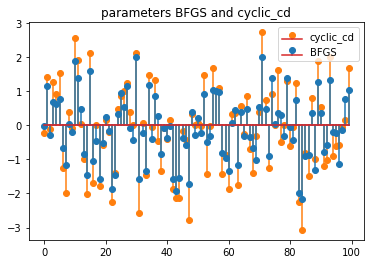

In [294]:
# #print (old_w_j - step * grad_j, lambd, w_min)

# # print (lambd, lambda_max )
# plt.stem(w, label="cyclic_cd", linefmt="C1-", markerfmt="C1o")
# plt.stem(w_min, label='BFGS')
# plt.legend(loc=1)
# plt.title('parameters BFGS and cyclic_cd')

In [248]:

lips_const = np.linalg.norm(X, axis = 0) ** 2 / 4.
print ( lips_const)

Xj = X[:,7]  # the j-th column of x

lips_const_j = np.linalg.norm(Xj) ** 2 / 4 
   
    
print (lips_const_j)    

[265.28015904 240.56908526 250.18648779 247.64684272 251.77996138
 250.5318719  253.77926061 242.25612708 250.75952293 252.24303091
 259.91251837 255.11935899 243.28839836 250.52066013 242.24286099
 266.27141834 226.59723773 264.55405085 266.26676849 271.54012787
 257.95954502 256.89962584 261.06405187 261.62095072 243.15139762
 253.77419728 261.63620488 258.04962907 240.66756029 244.79681303
 255.85704247 247.55632861 255.37719224 242.18898259 248.38216757
 255.95353442 251.7520225  239.63978497 241.67042342 270.48537006
 256.67785293 247.01333357 250.35151375 248.08883881 261.44262171
 238.37095191 240.80982879 240.45932188 249.84241923 243.32882683
 246.21119289 272.23778936 254.52605412 252.40851086 231.7534515
 241.32479025 248.35074034 239.24872176 241.73901398 244.22092615
 249.78321281 250.37893452 261.4750619  241.43800168 228.86080929
 234.97726574 238.92298432 245.23013862 259.88972163 248.80503181
 233.01389186 237.47517066 251.99553409 243.36701589 268.47096298
 253.447951

In [ ]:
lambda_max_lasso = norm(X.dot(y), ord=np.inf)
lambd = lambda_max_lasso / 5.

Code:
- a simple proximal gradient solver for the Lasso
- a prox CD solver for the Lasso
and compare them on this dataset. 
Do the plots in terms of epochs, not updates (to be fair to CD).

In [ ]:
X, y = simu(coefs, n_samples=1000, for_logreg=True)
lambda_max = norm(X.T.dot(y), ord= np.inf) / 2.
lamb = lambda_max / 10.  
# much easier to parametrize lambda as a function of lambda_max than 
# to take random values like 0.1 in previous Labs


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def soft_thresh(x, u):
    """Soft thresholding of x at level u"""
    return np.maximum(0., np.abs(x) - u)


def cd_logreg(X, y, lamb, n_iter):
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    Xw = X.dot(w)
    
    # TODO
    lips_const = np.linalg.norm(X, axis = 0) ** 2 / 4.
    # END TODO
    all_objs = np.zeros((n_iter, 1))
    
    
    for t in range(n_iter):
        for j in range(n_features):  # cyclic cd 
            old_w_j = w[j]
            
            Xj = X[:,j]  # the j-th column of x         
            # lips_const_j = np.linalg.norm(Xj) ** 2 / 4 
            step = 1 /  lips_const[j]
            grad_j =  - np.sum(np.multiply(y, Xj) / (1 + np.exp(y * Xw)))
            diff_w_j = old_w_j - step * grad_j
            
            
#             if old_w_j > 0:  
#                 grad_j = lamb - np.sum(np.multiply(y, xj) / (1 + np.exp(y * Xw)))
#             elif  old_w_j < 0:    
#                 grad_j = -lamb - np.sum(np.multiply(y, xj) / (1 + np.exp(y * Xw)))
#             elif old_w_j == 0: 
                
                
            w[j] =  np.sign(diff_w_j) * soft_thresh(diff_w_j, lamb)
           # if t  % 100 == 0:
            #   print (old_w_j - step * grad_j, w[j], lamb)
            
            if old_w_j != w[j]:
                Xw +=  Xj * (w[j] - old_w_j)
            #END TODO
            
        all_objs[t] = np.log(1. + np.exp(-y * Xw)).sum() + lamb * norm(w, ord=1)
    
    return w, all_objs